<a href="https://colab.research.google.com/github/jpantojac/dMet/blob/main/modelamiento/dMet_modelamiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Bienvenido al Diplomado de Meteorologia**


---




En este espacio se realizaran las entregas de los ejercicios propuestos


In [6]:
#!apt-get install libproj-dev proj-data proj-bin
#!apt-get install libgeos-dev
#!pip install cython
#!pip install cartopy
#!pip install pydrive
#!pip install netCDF4

In [4]:
#!apt-get -qq install python-cartopy python3-cartopy
#!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
#!pip install shapely --no-binary shapely

In [5]:
#!pip install -U -q wrf-python

In [1]:
import os

print("Bienvenido")

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1dh0EcrDUALX4lhTLVFmvndxhQIAyqaJe'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('wrfout_d02_2022-10-13_00_00_00.nc')  
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))
print("Hecho")


Bienvenido
Hecho


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

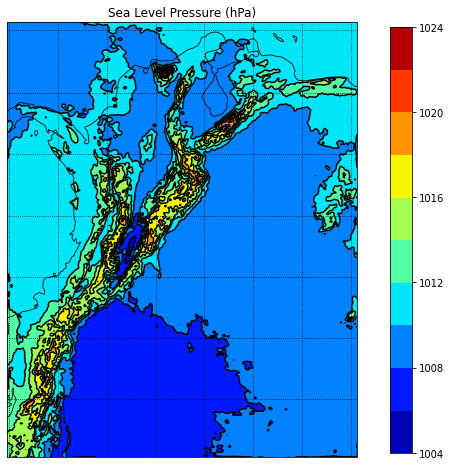

In [8]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
 

from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,cartopy_ylim, latlon_coords)

# Open the NetCDF file
ncfile = Dataset("/content/wrfout_d02_2022-10-13_00_00_00.nc")
# Get the sea level pressure
slp = getvar(ncfile, "slp")

# Smooth the sea level pressure since it tends to be noisy near the
# mountains
smooth_slp = smooth2d(slp, 3, cenweight=4)

# Get the latitude and longitude points
lats, lons = latlon_coords(slp)

# Get the cartopy mapping object
cart_proj = get_cartopy(slp)

# Create a figure
fig = plt.figure(figsize=(12,8))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, linewidth=.5, edgecolor="black")
ax.coastlines('50m', linewidth=0.8)


# Make the contour outlines and filled contours for the smoothed sea level
# pressure.
plt.contour(to_np(lons), to_np(lats), to_np(smooth_slp), 10, colors="black",
            transform=crs.PlateCarree())
plt.contourf(to_np(lons), to_np(lats), to_np(smooth_slp), 10,
             transform=crs.PlateCarree(),
             cmap=get_cmap("jet"))

# Add a color bar
plt.colorbar(ax=ax, shrink=.98)

# Set the map bounds
ax.set_xlim(cartopy_xlim(smooth_slp))
ax.set_ylim(cartopy_ylim(smooth_slp))

# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")

plt.title("Sea Level Pressure (hPa)")

#plt.show()
plt.savefig("/content/sample_data/salida.png")
plt.show()



Cross Section

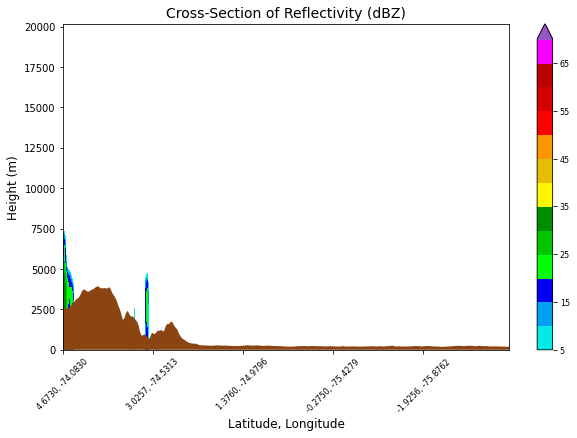

In [18]:
import numpy as np
from matplotlib import pyplot
from matplotlib.cm import get_cmap
from matplotlib.colors import from_levels_and_colors
from cartopy import crs
from cartopy.feature import NaturalEarthFeature, COLORS
from netCDF4 import Dataset
from wrf import (getvar, to_np, get_cartopy, latlon_coords, vertcross,
                 cartopy_xlim, cartopy_ylim, interpline, CoordPair)
# Open the NetCDF file
wrf_file = Dataset("/content/wrfout_d02_2022-10-13_00_00_00.nc")

# Define the cross section start and end points
cross_start = CoordPair(lat=4.67, lon=-74.07)
cross_end = CoordPair(lat=-3.5, lon=-76.3)

# Get the WRF variables
ht = getvar(wrf_file, "z", timeidx=-1)
ter = getvar(wrf_file, "ter", timeidx=-1)
dbz = getvar(wrf_file, "dbz", timeidx=-1)
max_dbz = getvar(wrf_file, "mdbz", timeidx=-1)
Z = 10**(dbz/10.) # Use linear Z for interpolation

# Compute the vertical cross-section interpolation.  Also, include the
# lat/lon points along the cross-section in the metadata by setting latlon
# to True.
z_cross = vertcross(Z, ht, wrfin=wrf_file,
                    start_point=cross_start,
                    end_point=cross_end,
                    latlon=True, meta=True)

# Convert back to dBz after interpolation
dbz_cross = 10.0 * np.log10(z_cross)

# Add back the attributes that xarray dropped from the operations above
dbz_cross.attrs.update(z_cross.attrs)
dbz_cross.attrs["description"] = "radar reflectivity cross section"
dbz_cross.attrs["units"] = "dBZ"

# To remove the slight gap between the dbz contours and terrain due to the
# contouring of gridded data, a new vertical grid spacing, and model grid
# staggering, fill in the lower grid cells with the first non-missing value
# for each column.

# Make a copy of the z cross data. Let's use regular numpy arrays for this.
dbz_cross_filled = np.ma.copy(to_np(dbz_cross))

# For each cross section column, find the first index with non-missing
# values and copy these to the missing elements below.
for i in range(dbz_cross_filled.shape[-1]):
    column_vals = dbz_cross_filled[:,i]
    # Let's find the lowest index that isn't filled. The nonzero function
    # finds all unmasked values greater than 0. Since 0 is a valid value
    # for dBZ, let's change that threshold to be -200 dBZ instead.
    first_idx = int(np.transpose((column_vals > -200).nonzero())[0])
    dbz_cross_filled[0:first_idx, i] = dbz_cross_filled[first_idx, i]

# Get the terrain heights along the cross section line
ter_line = interpline(ter, wrfin=wrf_file, start_point=cross_start,
                      end_point=cross_end)

# Get the lat/lon points
lats, lons = latlon_coords(dbz)

# Get the cartopy projection object
cart_proj = get_cartopy(dbz)

# Create the figure
fig = pyplot.figure(figsize=(10,6))
ax_cross = pyplot.axes()

dbz_levels = np.arange(5., 75., 5.)

# Create the color table found on NWS pages.
dbz_rgb = np.array([[4,233,231],
                    [1,159,244], [3,0,244],
                    [2,253,2], [1,197,1],
                    [0,142,0], [253,248,2],
                    [229,188,0], [253,149,0],
                    [253,0,0], [212,0,0],
                    [188,0,0],[248,0,253],
                    [152,84,198]], np.float32) / 255.0

dbz_map, dbz_norm = from_levels_and_colors(dbz_levels, dbz_rgb,
                                           extend="max")

# Make the cross section plot for dbz
dbz_levels = np.arange(5.,75.,5.)
xs = np.arange(0, dbz_cross.shape[-1], 1)
ys = to_np(dbz_cross.coords["vertical"])
dbz_contours = ax_cross.contourf(xs,
                                 ys,
                                 to_np(dbz_cross_filled),
                                 levels=dbz_levels,
                                 cmap=dbz_map,
                                 norm=dbz_norm,
                                 extend="max")
# Add the color bar
cb_dbz = fig.colorbar(dbz_contours, ax=ax_cross)
cb_dbz.ax.tick_params(labelsize=8)

# Fill in the mountain area
ht_fill = ax_cross.fill_between(xs, 0, to_np(ter_line),
                                facecolor="saddlebrown")

# Set the x-ticks to use latitude and longitude labels
coord_pairs = to_np(dbz_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str() for pair in to_np(coord_pairs)]

# Set the desired number of x ticks below
num_ticks = 5
thin = int((len(x_ticks) / num_ticks) + .5)
ax_cross.set_xticks(x_ticks[::thin])
ax_cross.set_xticklabels(x_labels[::thin], rotation=45, fontsize=8)

# Set the x-axis and  y-axis labels
ax_cross.set_xlabel("Latitude, Longitude", fontsize=12)
ax_cross.set_ylabel("Height (m)", fontsize=12)

# Add a title
ax_cross.set_title("Cross-Section of Reflectivity (dBZ)", {"fontsize" : 14})

pyplot.show()